In [1]:
from __future__ import annotations

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from carps.analysis.process_data import get_interpolated_performance_df, load_logs


def print_overview(df_trials: pd.DataFrame) -> None:
    print(df_trials.columns)
    print(df_trials["optimizer_id"].unique())
    print(df_trials["benchmark_id"].unique())
    print(df_trials["problem_id"].unique())
    print("Number of seeds", df_trials["seed"].nunique())


rundir = "../runs"

df, df_cfg = load_logs(rundir=rundir)
print_overview(df)
perf = get_interpolated_performance_df(df)
perf_time = get_interpolated_performance_df(df, x_column="time_norm")

[15:58:39] INFO     Load logs from `../runs/logs.csv` and associated configs from                ]8;id=623233;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/process_data.py\process_data.py]8;;\:]8;id=150082;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/process_data.py#94\94]8;;\
                    ../runs/logs_cfg.csv. Preprocess logs.                                                         

/scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/process_data.py:100: DtypeWarning: Columns (17,23,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(logs_fn)


[15:58:42] INFO     Processing raw logs. Normalize n_trials and costs. Calculate trajectory      ]8;id=383010;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/process_data.py\process_data.py]8;;\:]8;id=303293;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/process_data.py#15\15]8;;\
                    (incumbent cost).                                                                              

Index(['n_trials', 'trial_info__config', 'trial_info__instance',
       'trial_info__seed', 'trial_info__budget', 'trial_value__cost',
       'trial_value__time', 'trial_value__virtual_time', 'trial_value__status',
       'trial_value__starttime', 'trial_value__endtime', 'seed',
       'benchmark_id', 'problem_id', 'optimizer_id', 'problem.model_id',
       'problem.dataset_id', 'problem.surrogates_dir', 'trial_info__name',
       'trial_info__checkpoint', 'problem.problem.rng', 'problem.seed',
       'problem.budget_type', 'problem.bench', 'problem.instance',
       'problem.metric', 'problem.dimension', 'problem.fid', 'experiment_id',
       'n_trials_norm', 'trial_value__cost_norm', 'trial_value__cost_inc',
       'trial_value__cost_inc_norm', 'time', 'time_norm'],
      dtype='object')
['HEBO' 'RandomSearch' 'SMAC3-1.4-BlackBoxFacade' 'SMAC3-BlackBoxFacade']
['HPOB' 'HPOBench' 'BBOB' 'YAHPO']
['hpob/151/12' 'hpob/151/20' 'hpob/151/28' 'hpob/151/59' 'hpob/151/6'
 'hpob/subset/5489/3

[15:58:51] INFO     Create dataframe for neat plotting by aligning x-axis / interpolating        ]8;id=271632;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/process_data.py\process_data.py]8;;\:]8;id=907142;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/process_data.py#64\64]8;;\
                    budget.                                                                                        

[15:58:55] INFO     Create dataframe for neat plotting by aligning x-axis / interpolating        ]8;id=124459;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/process_data.py\process_data.py]8;;\:]8;id=438829;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/process_data.py#64\64]8;;\
                    budget.                                                                                        

In [2]:
from carps.analysis.critical_difference import calc_critical_difference
calc_critical_difference(df=df)


[15:59:04] INFO     Lost following experiments: optimizer_id                   HEBO       ]8;id=601049;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/critical_difference.py\critical_difference.py]8;;\:]8;id=771849;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/critical_difference.py#28\28]8;;\
                    RandomSearch  SMAC3-1.4-BlackBoxFacade  \                                                      
                    problem_id                                                                                     
                    yahpo/so/nb301/CIFAR10/None     NaN    -94.121498                                              
                    -94.140266                                                                                     
                    yahpo/so/rbv2_super/1053/None   NaN     -0.886232                                              
                    -0.935967                                                                                      
                    yahpo/so/rbv2_super/1063/None   NaN     -0.915074                                              
                    -0.905988                                                                                      
                    yahpo/so/rbv2_super/1457/None   NaN     -0.802621                                              
                    -0.819553                                                                                      
                    yahpo/so/rbv2_super/1468/None   NaN     -0.973820                                              
                    -0.972892                                                                                      
                    yahpo/so/rbv2_super/1479/None   NaN     -0.987557                                              
                    -0.976810                                                                                      
                    yahpo/so/rbv2_super/15/None     NaN     -0.984062                                              
                    -0.985433                                                                                      
                                                                                                                   
                    optimizer_id                   SMAC3-BlackBoxFacade                                            
                    problem_id                                                                                     
                    yahpo/so/nb301/CIFAR10/None              -94.368971                                            
                    yahpo/so/rbv2_super/1053/None             -0.963864                                            
                    yahpo/so/rbv2_super/1063/None             -0.916397                                            
                    yahpo/so/rbv2_super/1457/None             -0.857454                                            
                    yahpo/so/rbv2_super/1468/None             -0.967547                                            
                    yahpo/so/rbv2_super/1479/None             -0.966100                                            
                    yahpo/so/rbv2_super/15/None               -0.988708                                            

/scratch/hpc-prf-intexml/cbenjamins/.conda/envs/carpsexp/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


           INFO                                                                           ]8;id=506034;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/critical_difference.py\critical_difference.py]8;;\:]8;id=645306;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/critical_difference.py#39\39]8;;\
                    Methods: ['HEBO', 'RandomSearch', 'SMAC3-1.4-BlackBoxFacade',                                  
                    'SMAC3-BlackBoxFacade']                                                                        
                    Average ranks: [2.62626263 3.01515152 1.89393939 2.46464646]                                   
                    Groups: [array([0, 3]), array([1]), array([2])]                                                
                                                                                                                   

In [3]:
from carps.analysis.interval_estimates import plot_interval_estimates

# fig, axes = plot_interval_estimates(performance_data=perf, load_from_pickle=False, figure_filename="figures/plot_interval_estimates.pdf")

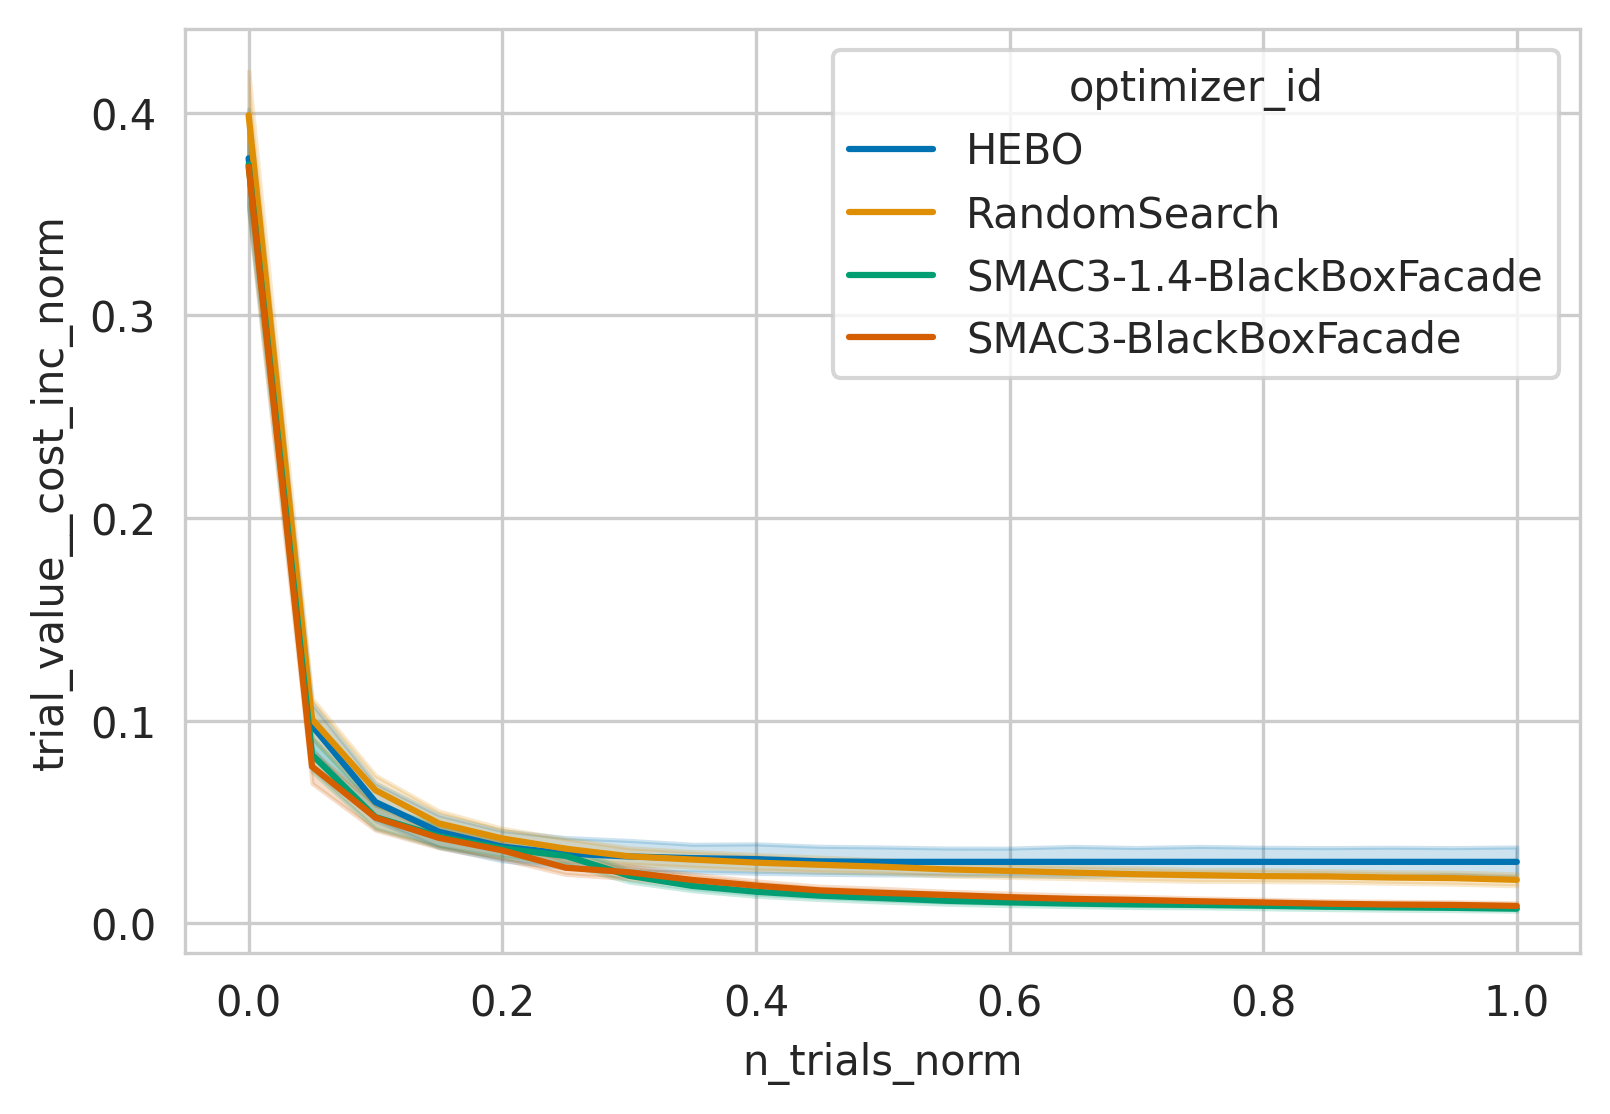

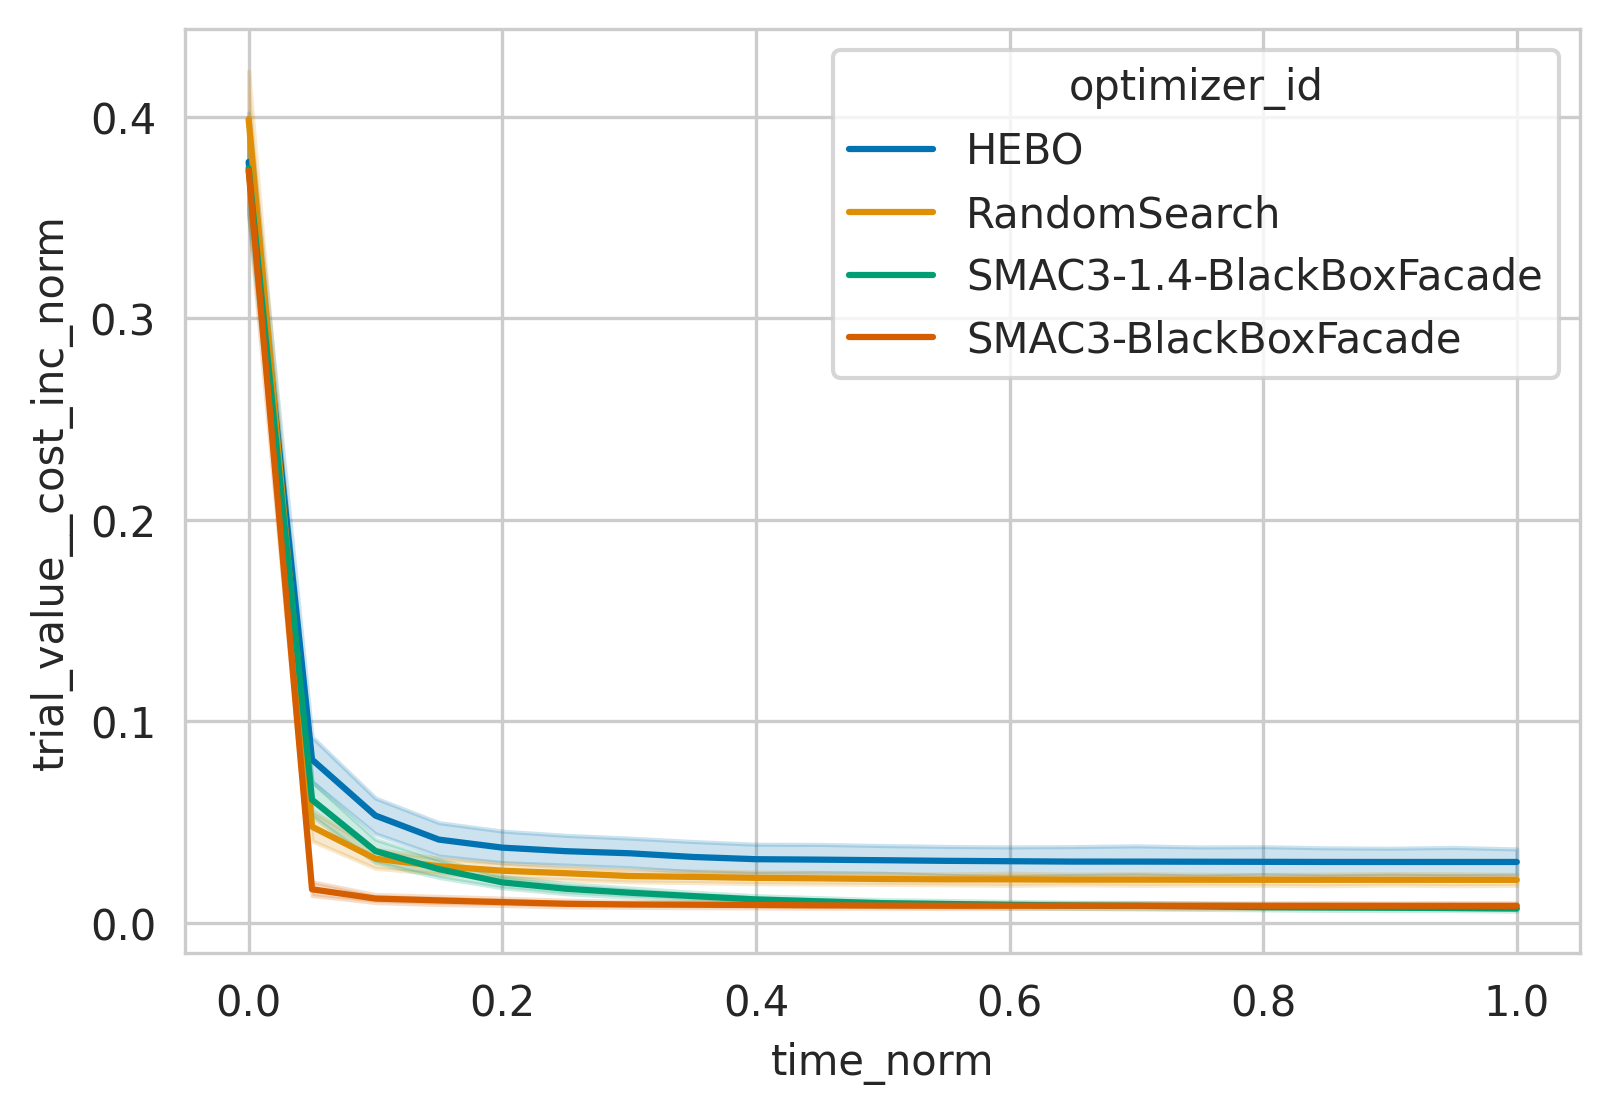

In [4]:
from carps.analysis.performance_over_time import plot_performance_over_time
lineplot_kwargs = dict()
fig, ax = plot_performance_over_time(df=perf, x="n_trials_norm", y="trial_value__cost_inc_norm", hue="optimizer_id", figure_filename="figures/performance_over_time_trials.pdf", figsize=(6,4), **lineplot_kwargs)
fig, ax = plot_performance_over_time(df=perf_time, x="time_norm", y="trial_value__cost_inc_norm", hue="optimizer_id", figure_filename="figures/performance_over_time_elapsed.pdf", figsize=(6,4), **lineplot_kwargs)

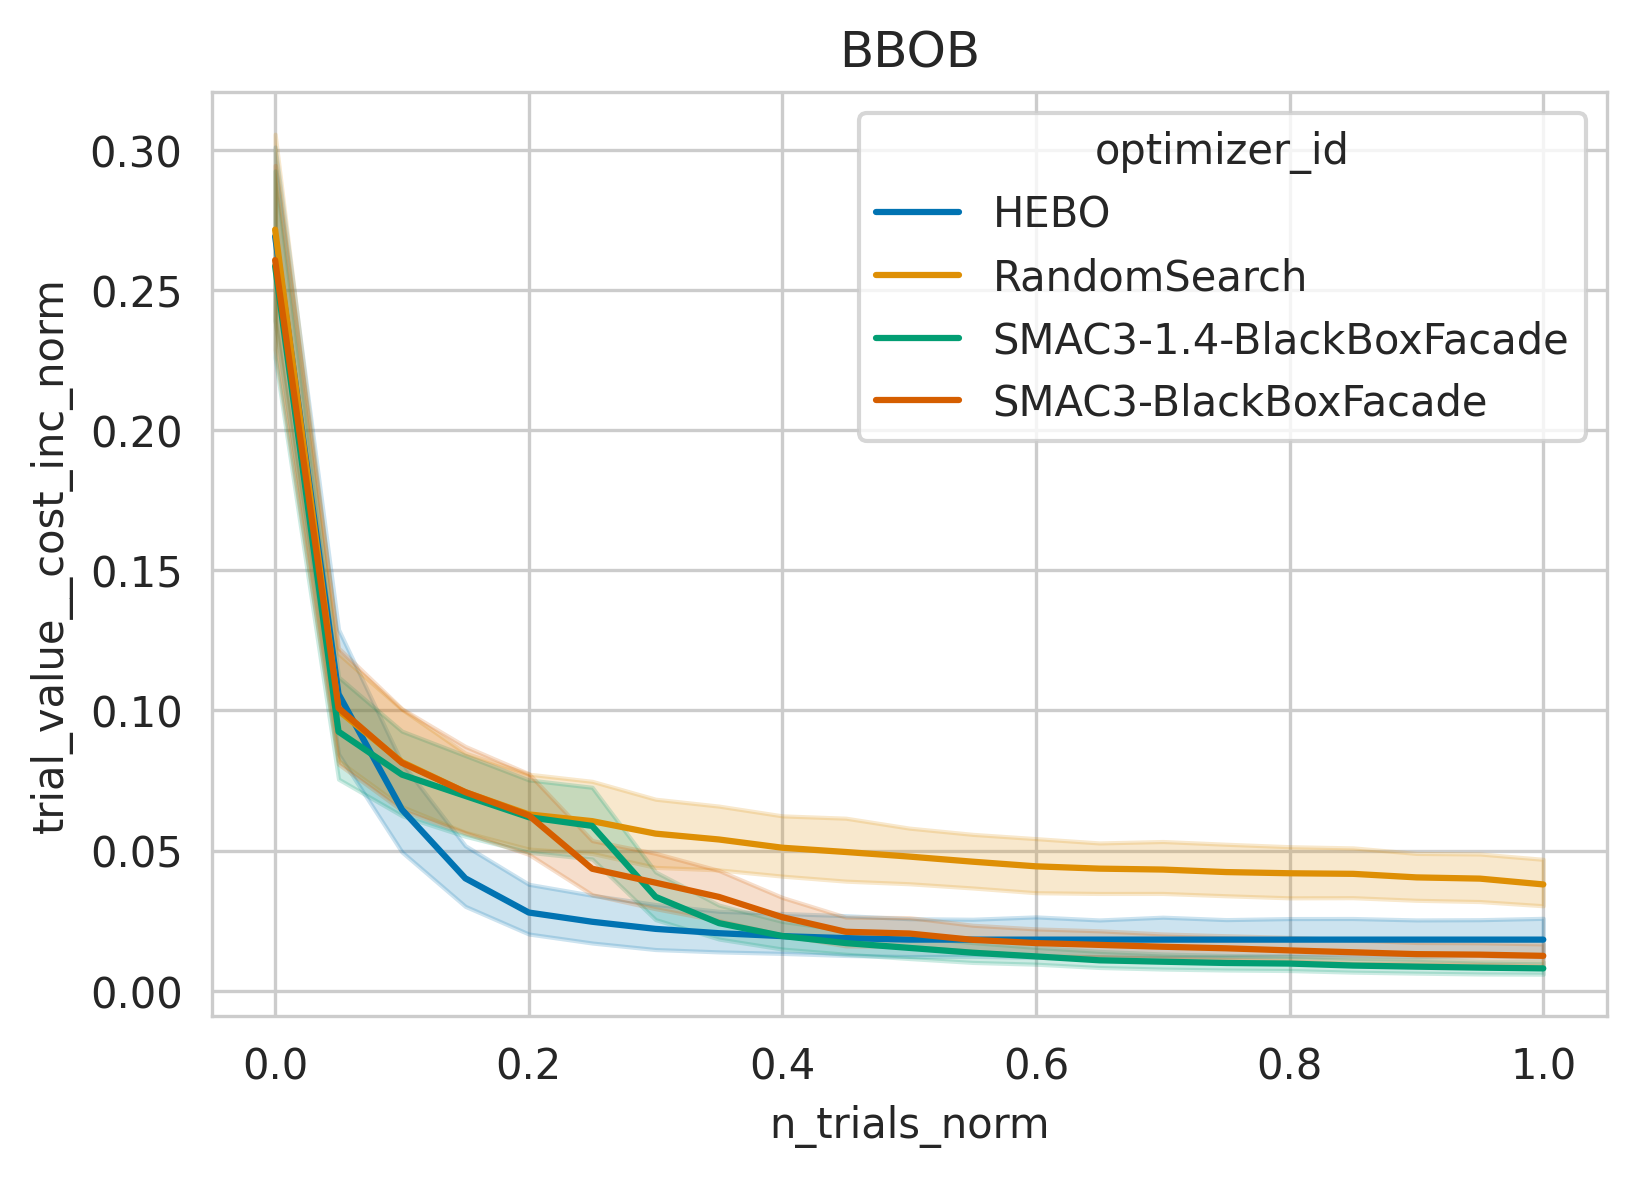

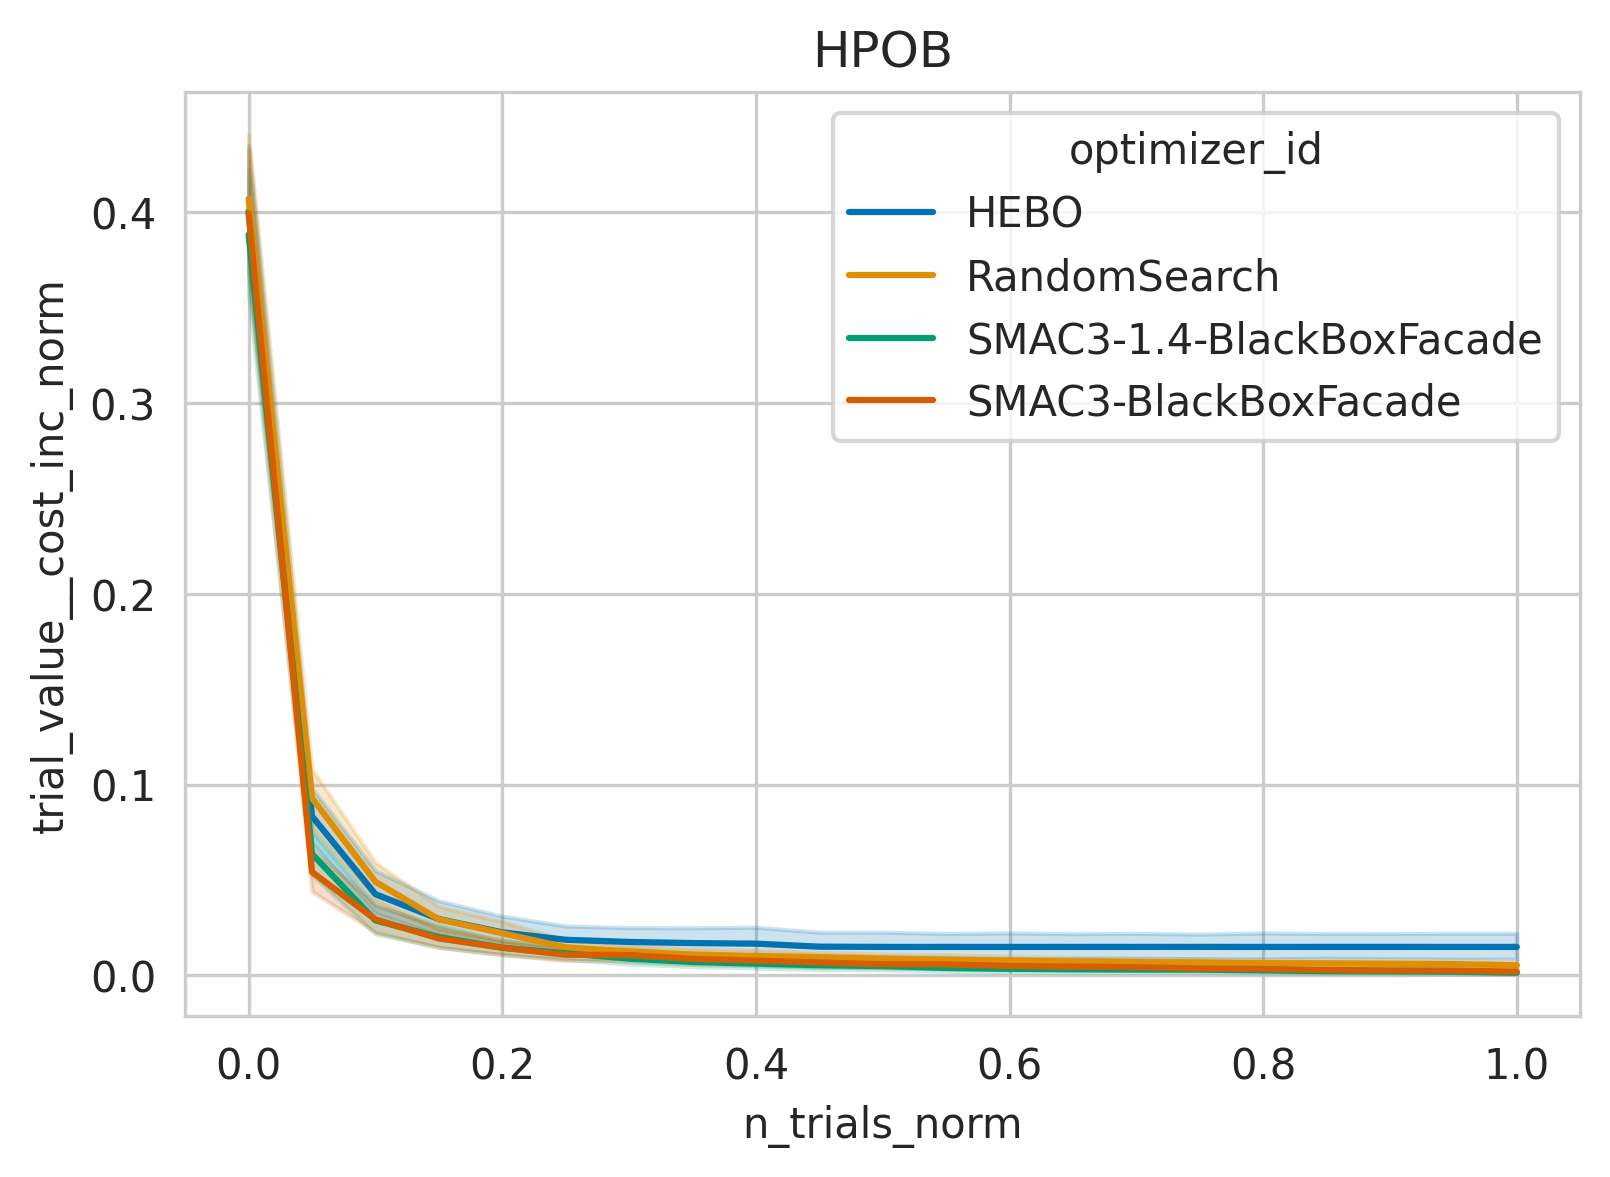

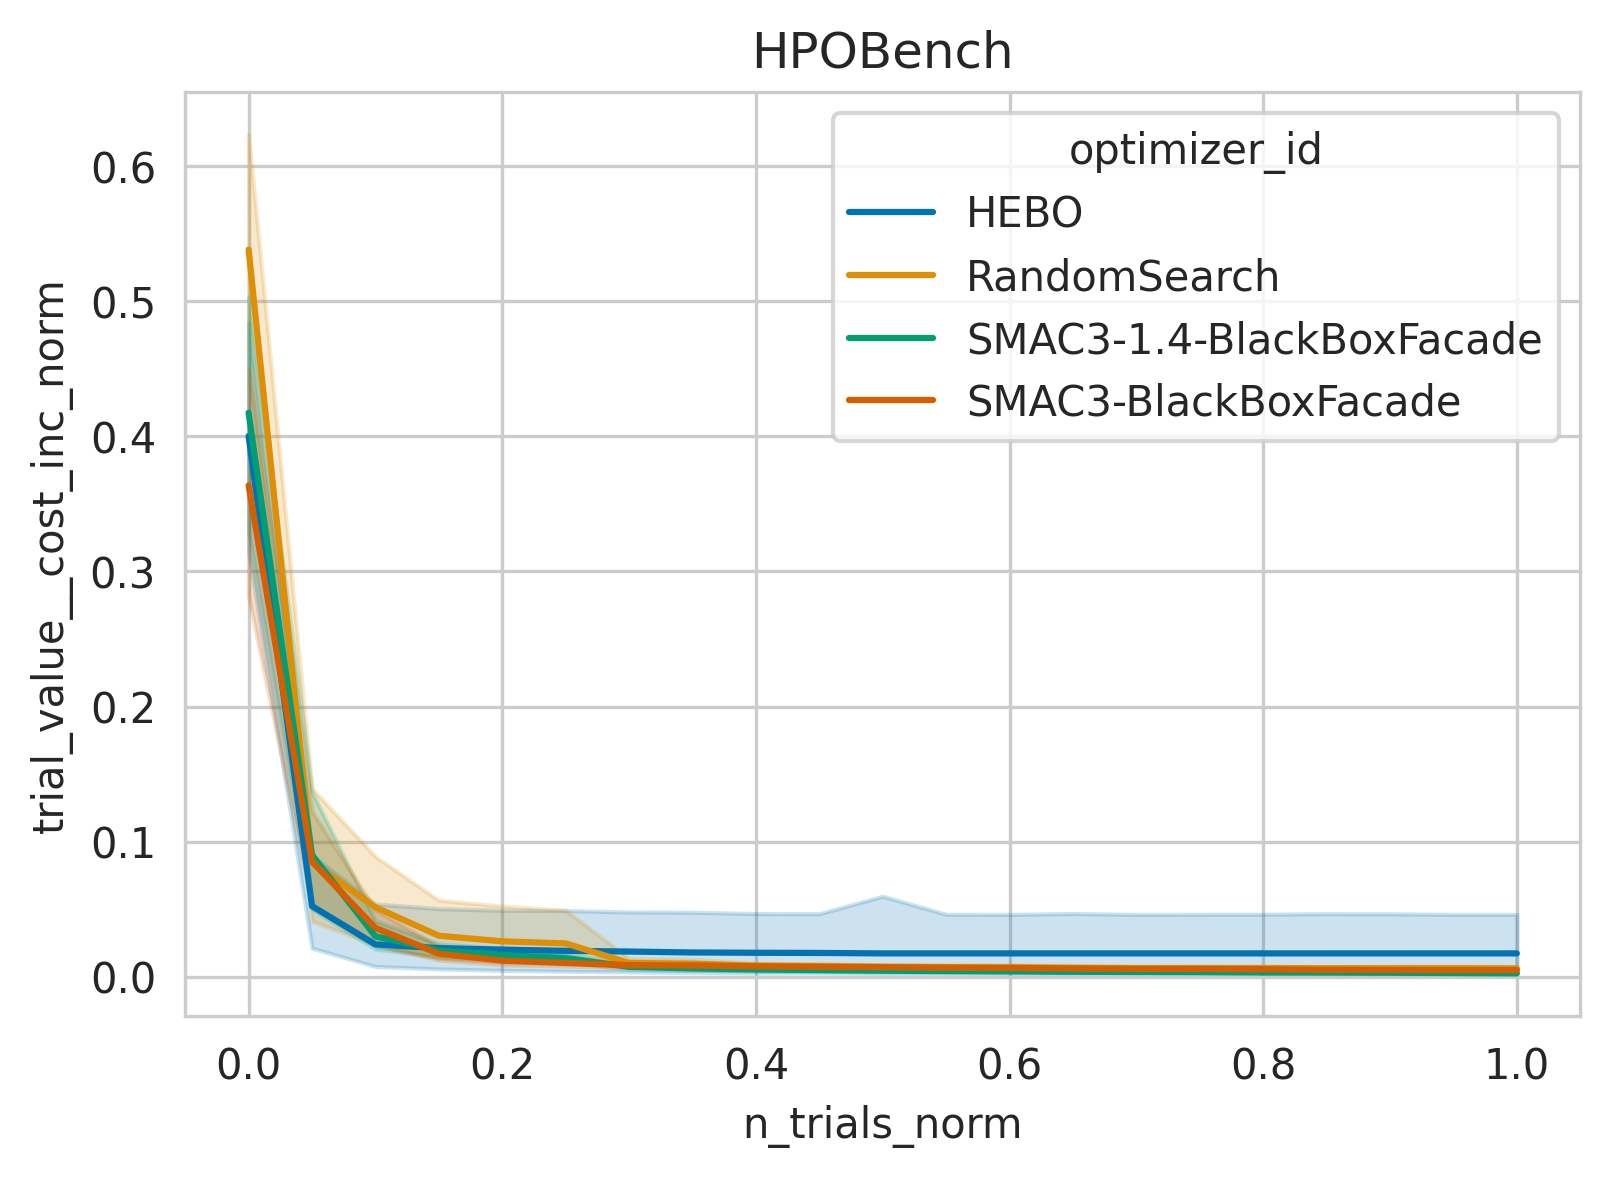

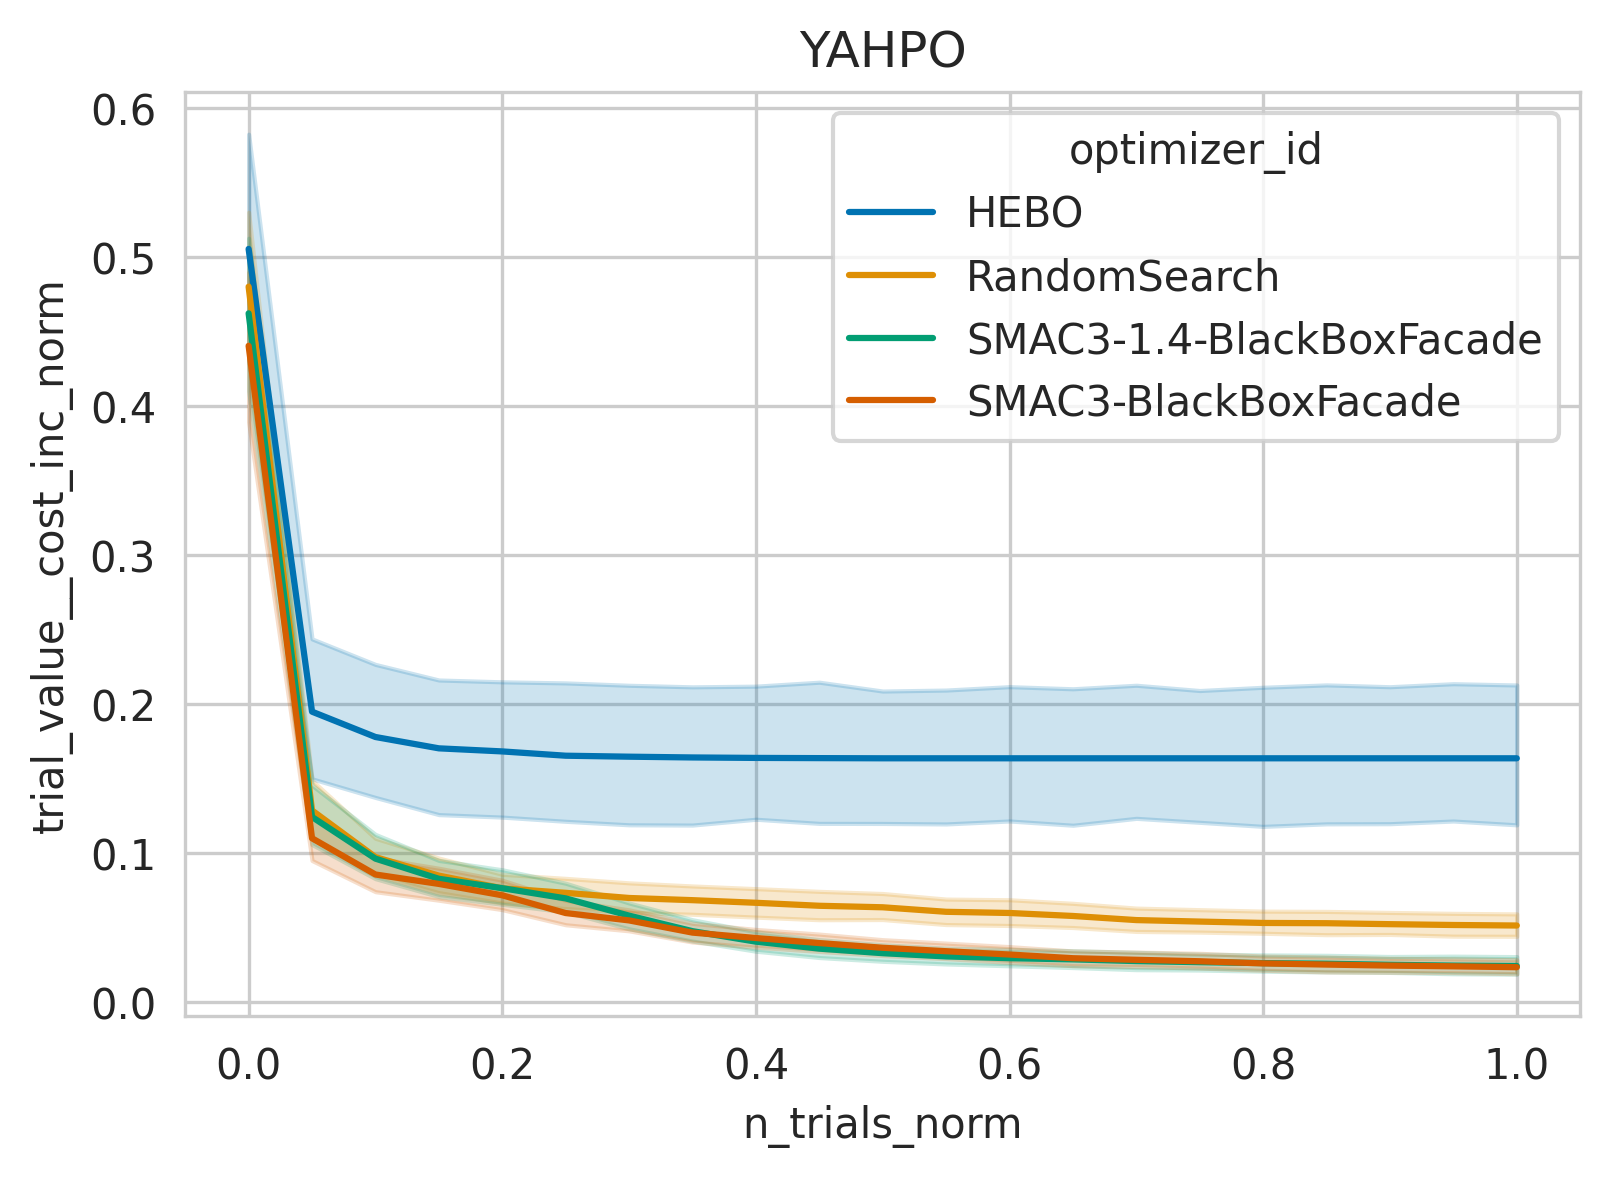

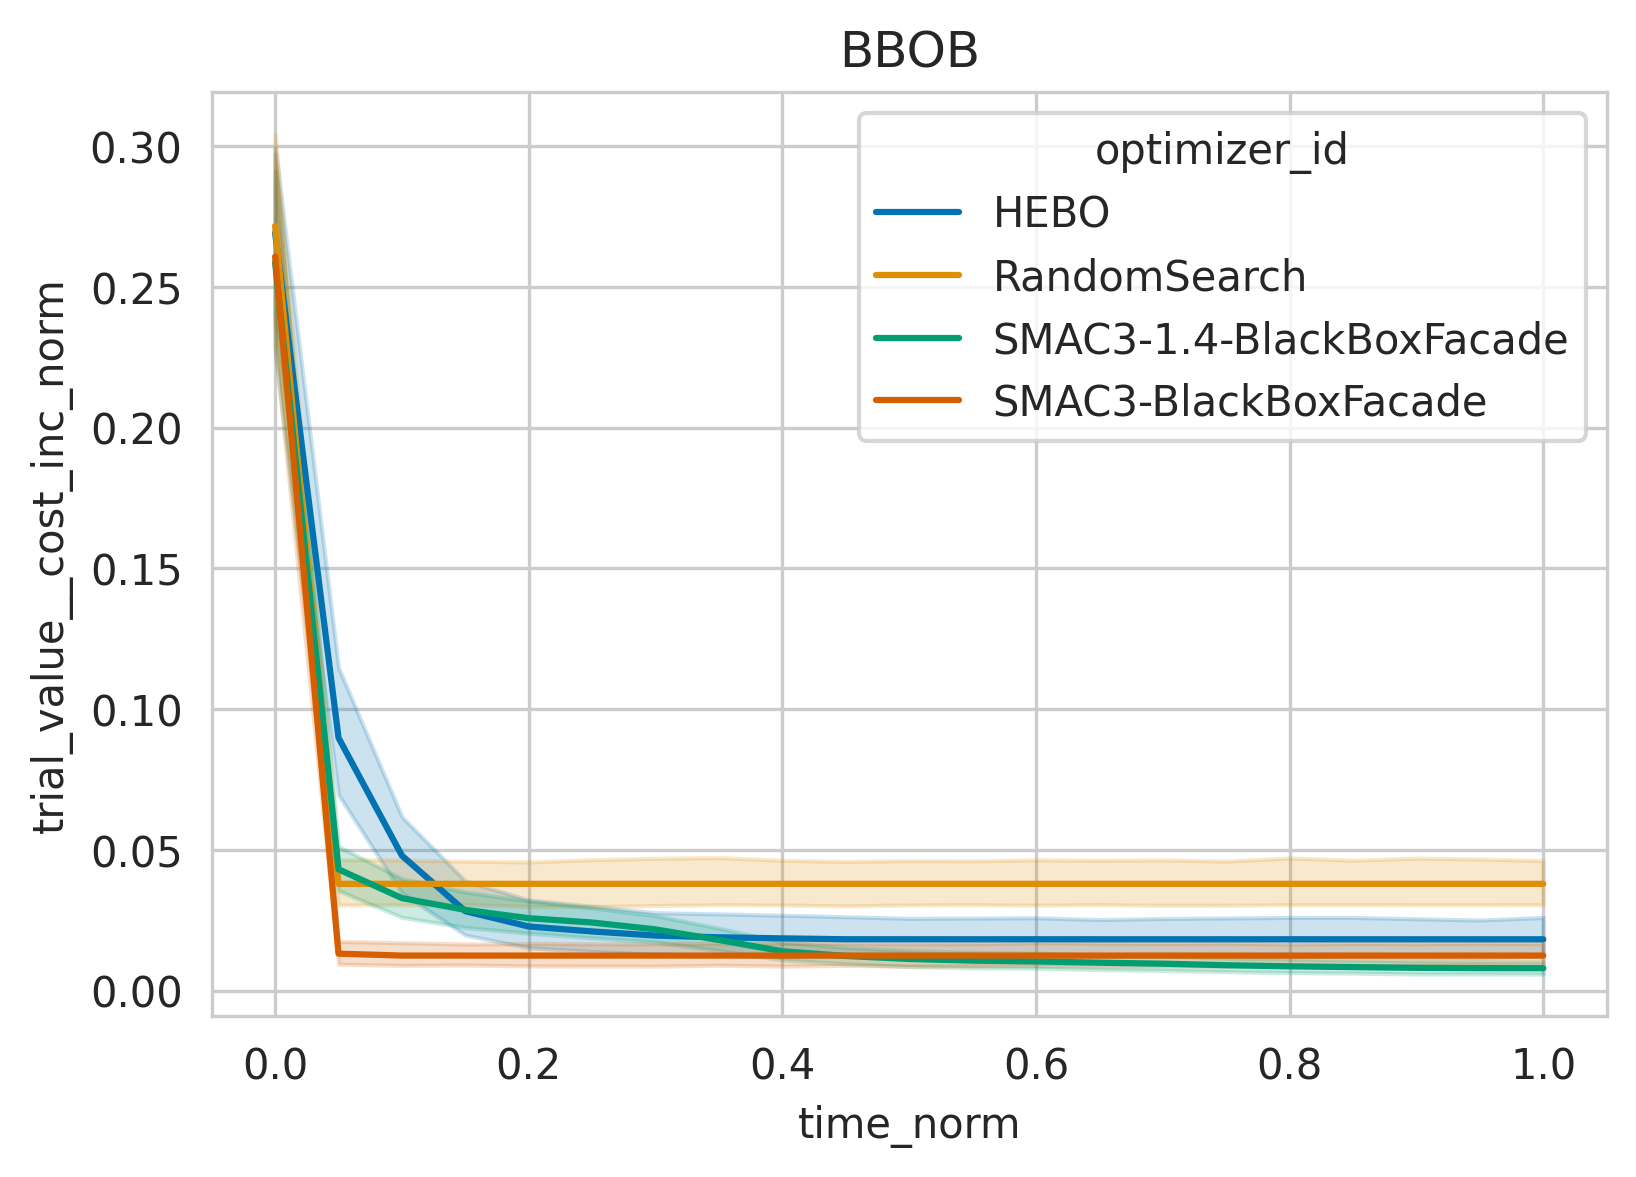

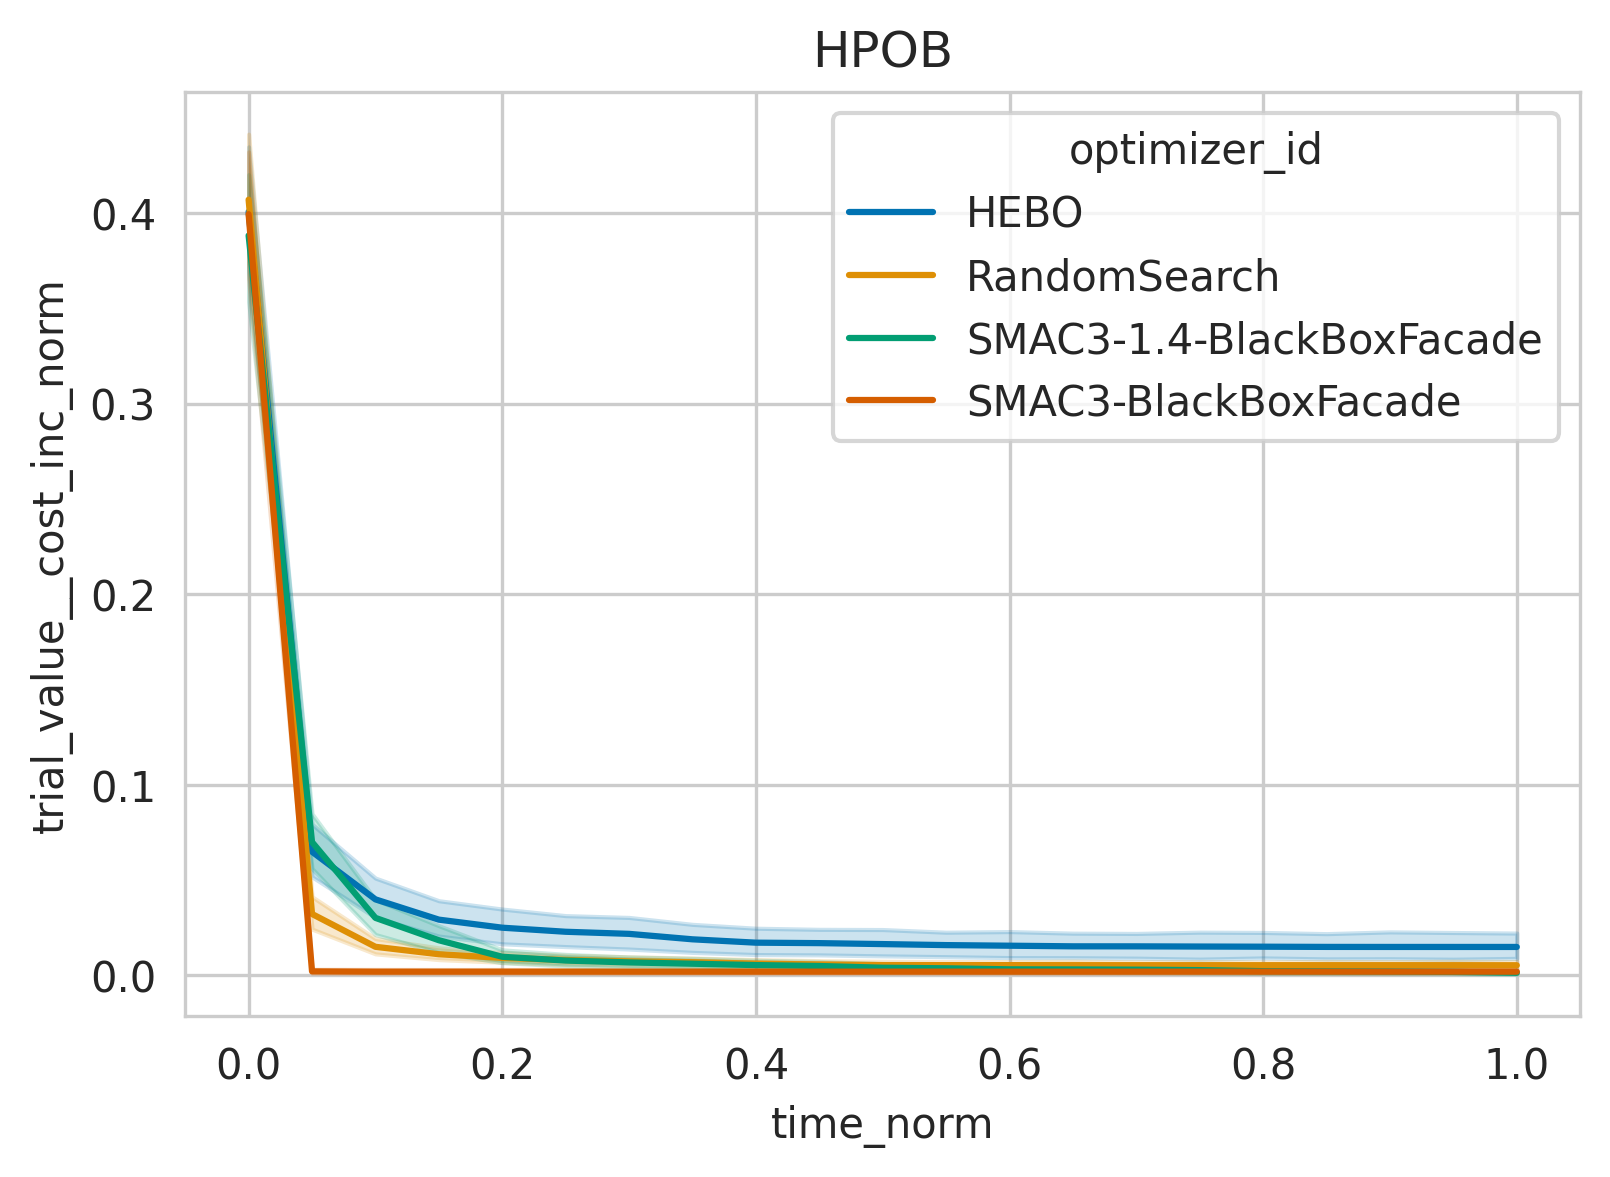

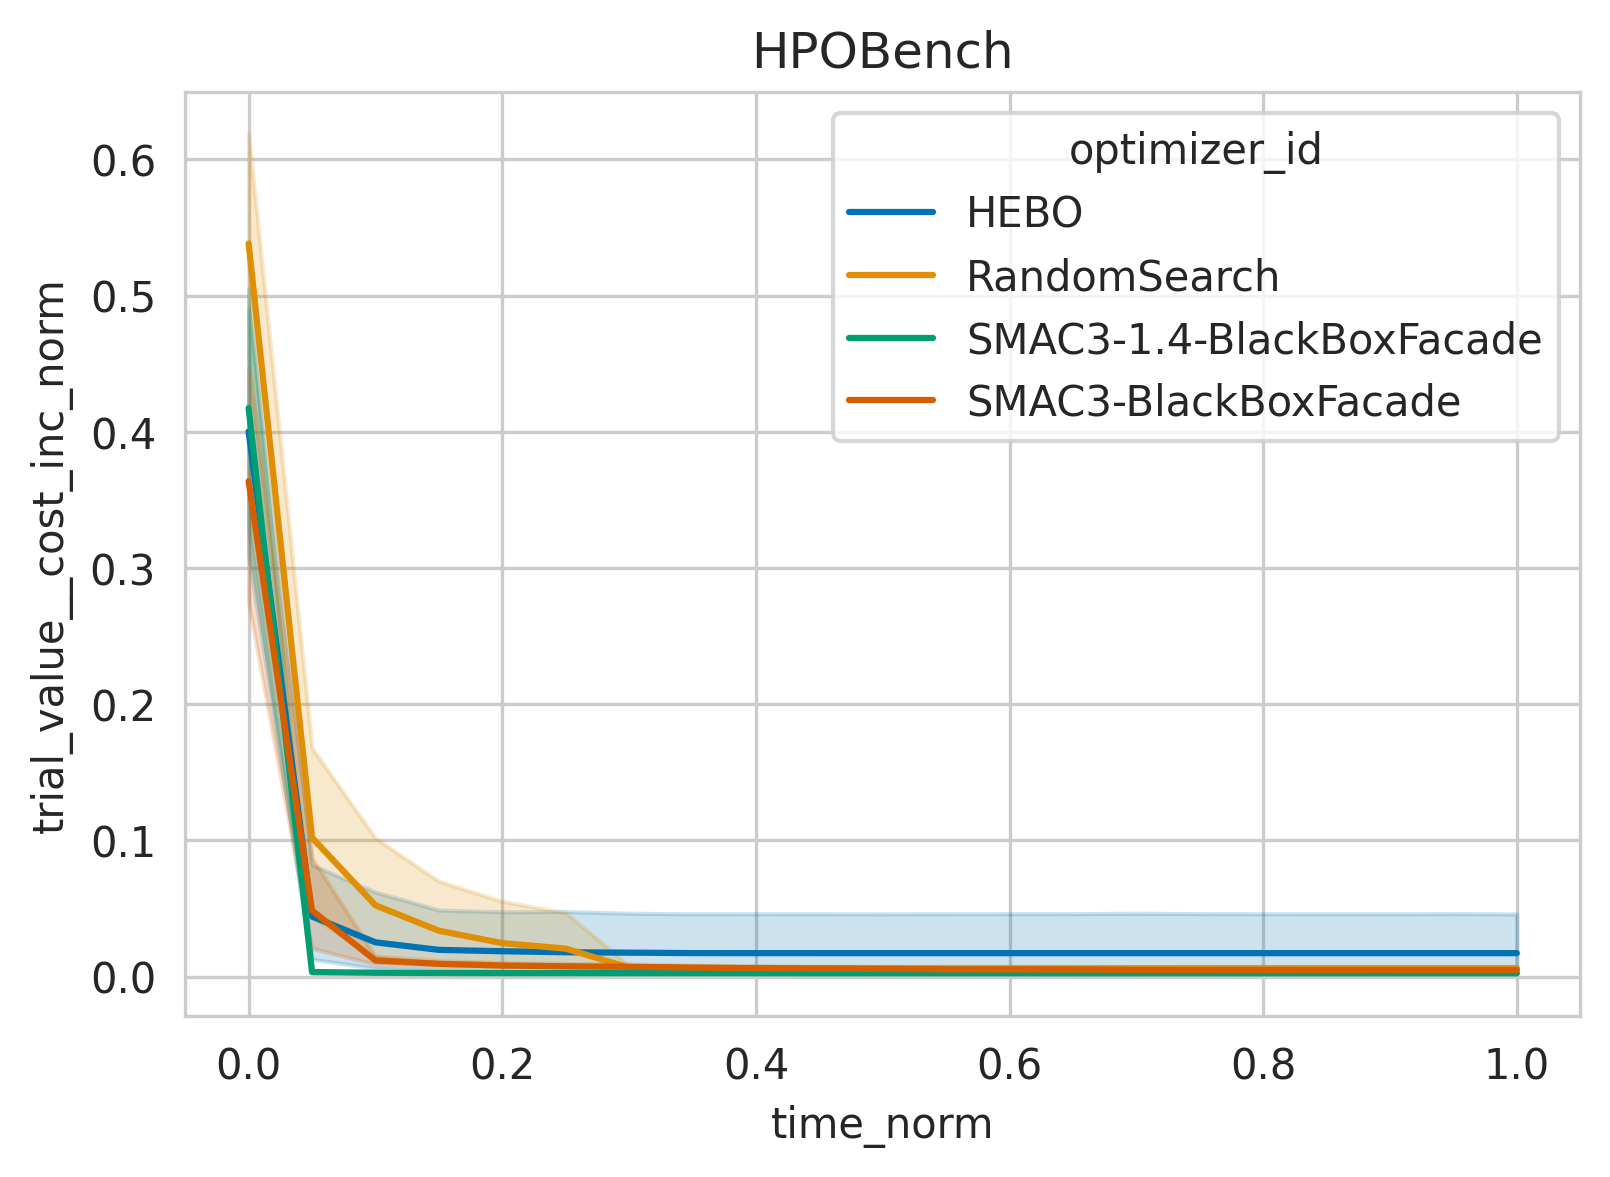

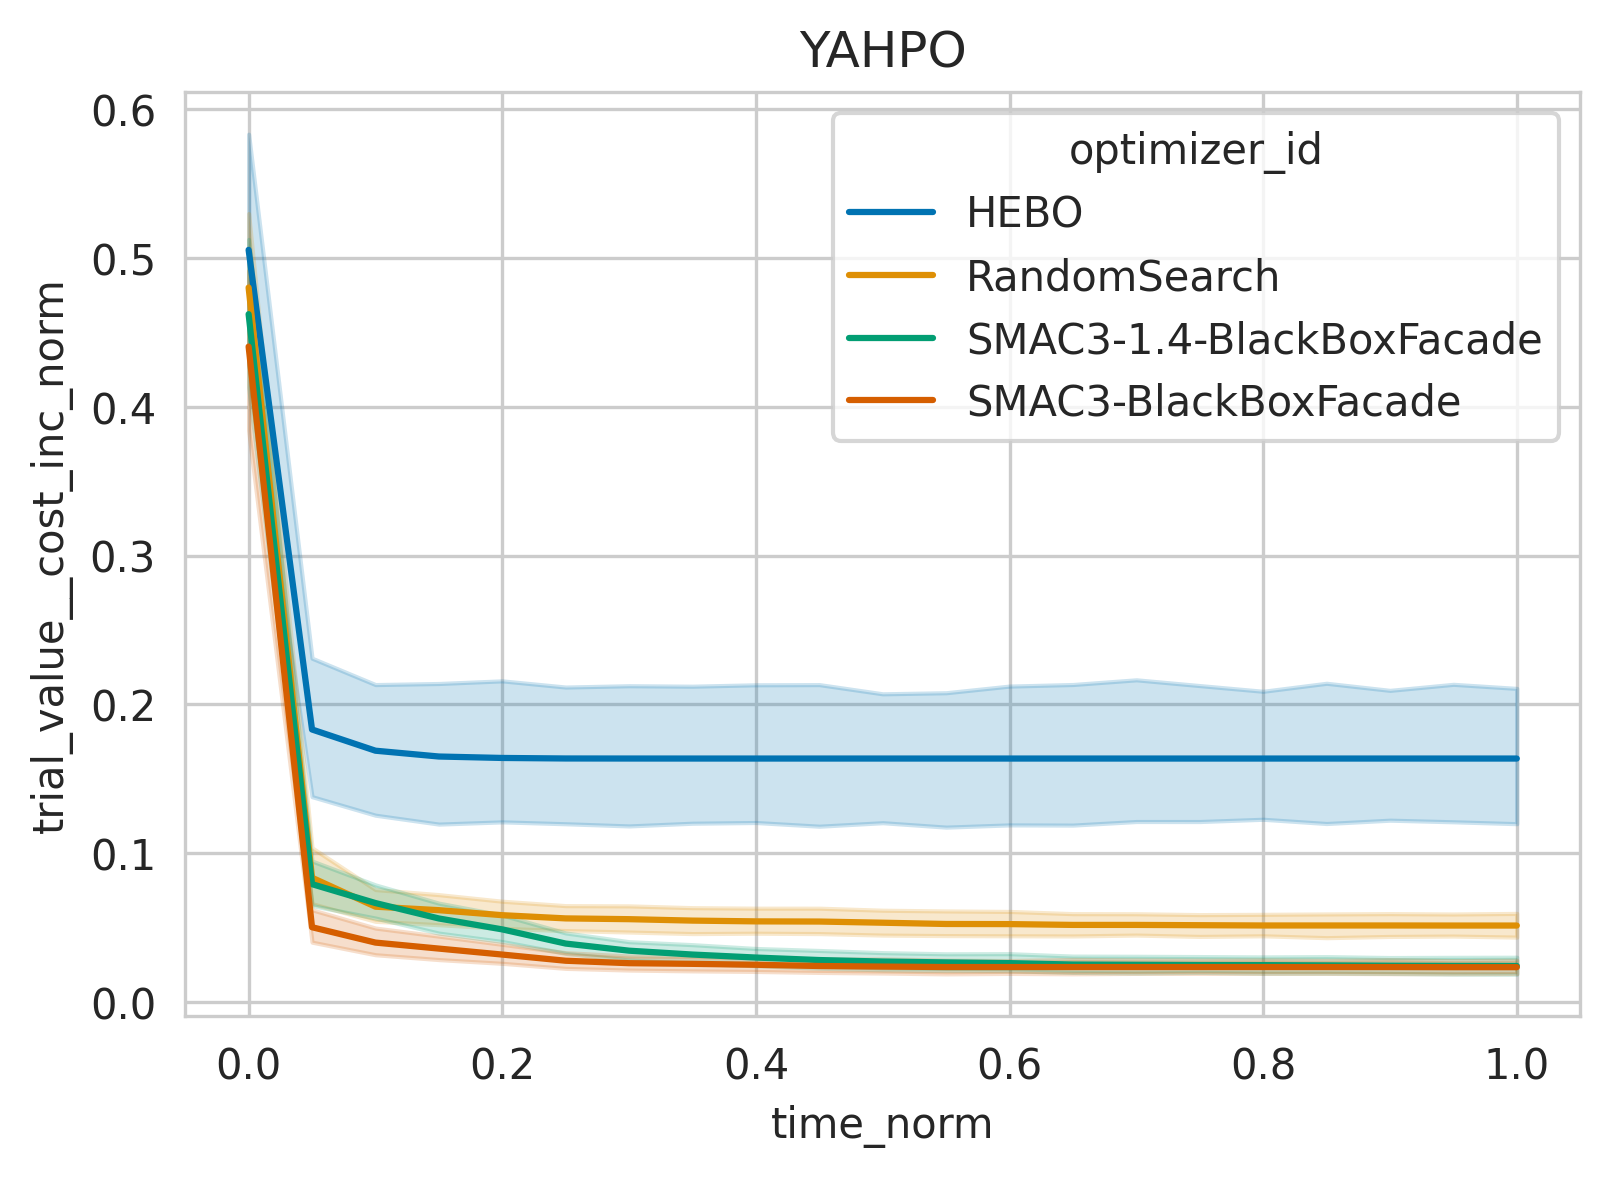

In [5]:
# Plot per benchmark
from carps.analysis.utils import get_color_palette, savefig
from carps.analysis.performance_over_time import plot_performance_over_time

palette = get_color_palette(perf)
lineplot_kwargs = dict()

# Iterations
for gid, gdf in perf.groupby(by="benchmark_id"):    
    figure_filename = f"figures/performance_over_time_trials_{gid}.pdf"
    fig, ax = plot_performance_over_time(df=gdf, x="n_trials_norm", y="trial_value__cost_inc_norm", hue="optimizer_id", figure_filename=figure_filename, figsize=(6,4), **lineplot_kwargs)
    ax.set_title(gid)
    savefig(fig, figure_filename)
    plt.show()

# Elapsed time
for gid, gdf in perf_time.groupby(by="benchmark_id"):    
    figure_filename = f"figures/performance_over_time_elapsed_{gid}.pdf"
    fig, ax = plot_performance_over_time(df=gdf, x="time_norm", y="trial_value__cost_inc_norm", hue="optimizer_id", figure_filename=figure_filename, figsize=(6,4), **lineplot_kwargs)
    ax.set_title(gid)
    savefig(fig, figure_filename)
    plt.show()

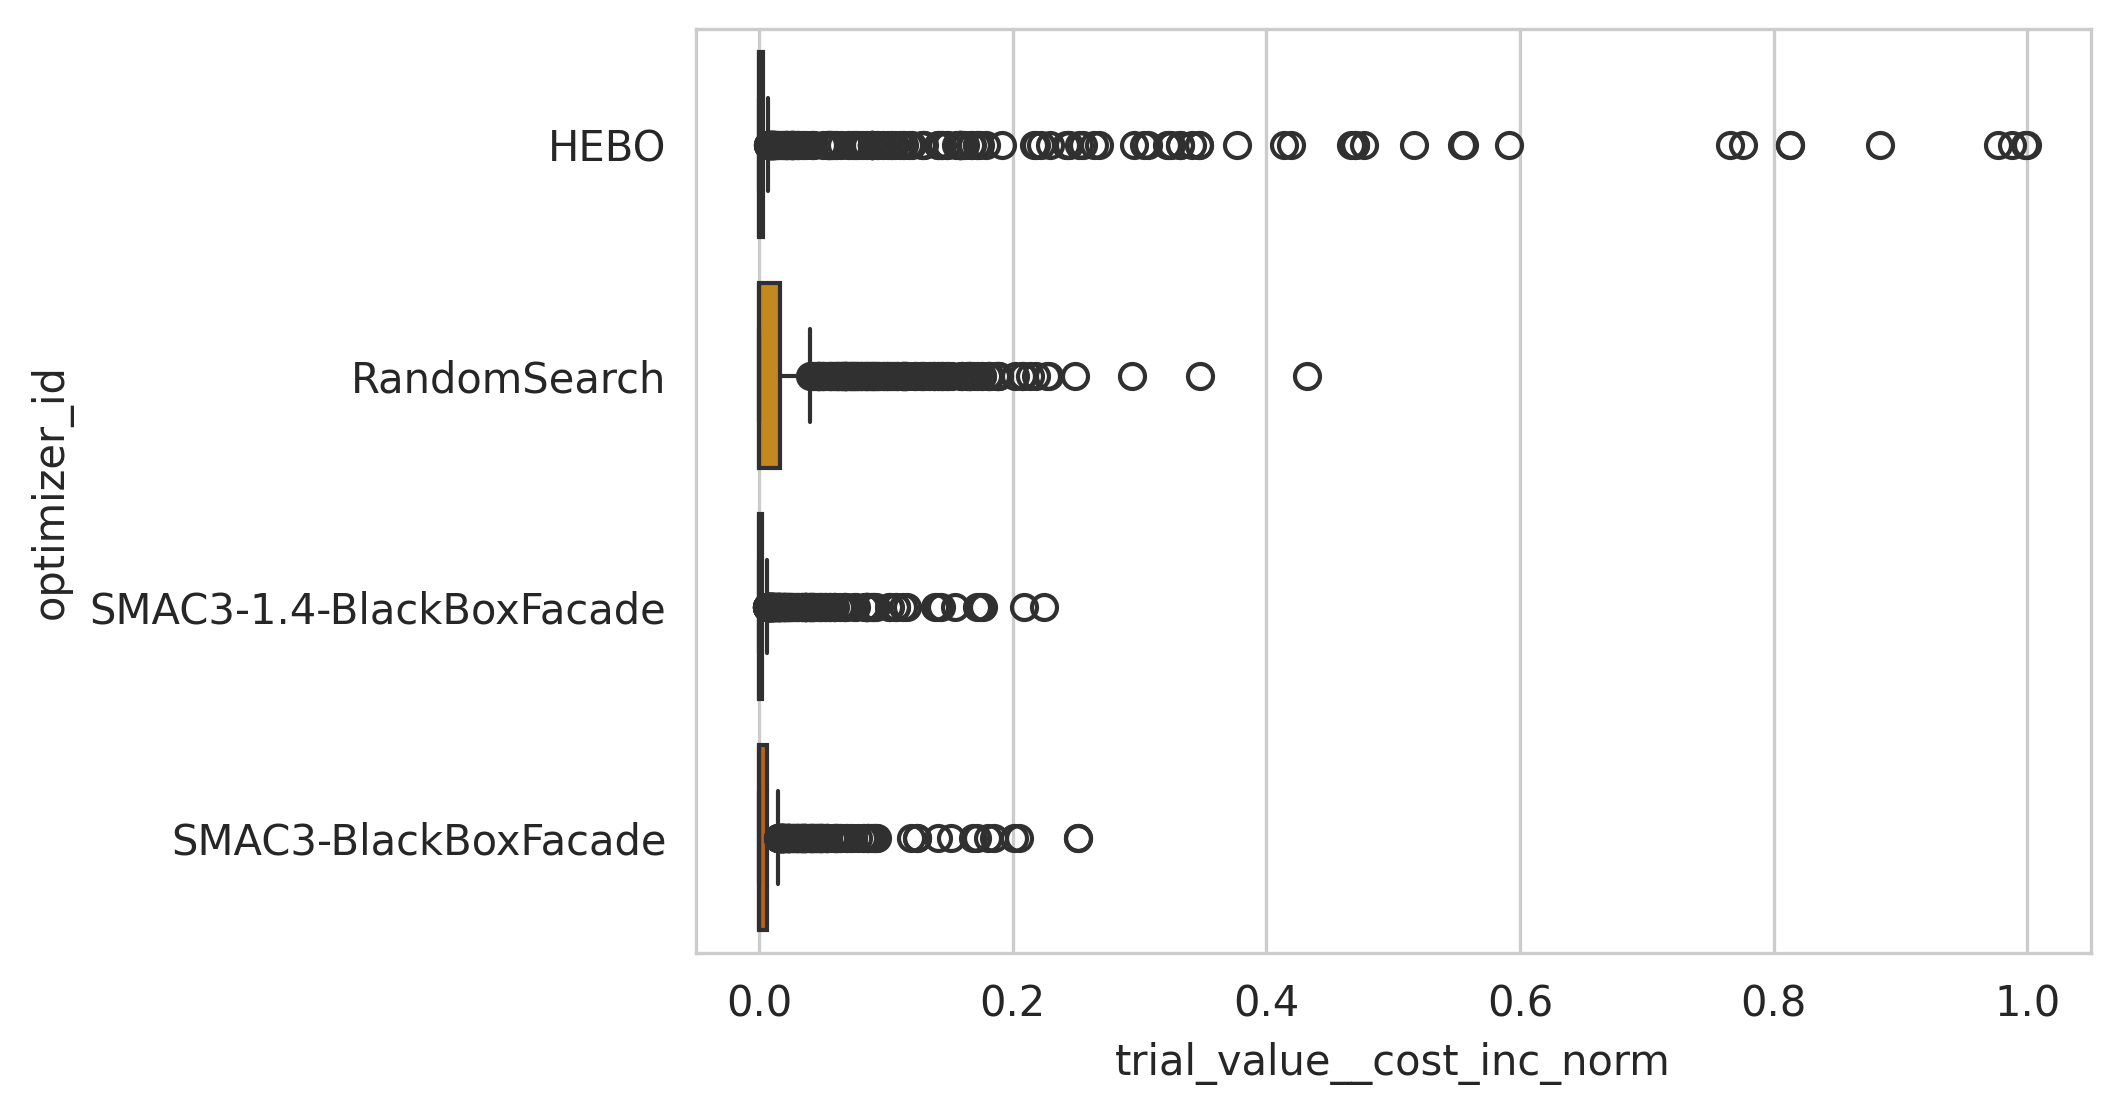

In [6]:
from carps.analysis.final_performance import plot_final_performance_boxplot

boxplot_kwargs = dict()
fig, ax = plot_final_performance_boxplot(df=perf, x="trial_value__cost_inc_norm", y="optimizer_id", hue="optimizer_id", figure_filename="figures/final_performance_boxplot.pdf", figsize=(6,4), **boxplot_kwargs)

In [7]:
max_val = df["n_trials_norm"].max()
error = df.groupby(by=["benchmark_id", "problem_id", "optimizer_id", "seed"])["n_trials_norm"].apply(lambda x: not np.isclose(x.max(), max_val))
error = error[error]
for i in error.index:
    print(i)

('BBOB', 'noiseless/5/1/0', 'HEBO', 1)
('BBOB', 'noiseless/5/1/0', 'HEBO', 2)
('BBOB', 'noiseless/5/1/0', 'HEBO', 3)
('BBOB', 'noiseless/5/1/0', 'HEBO', 4)
('BBOB', 'noiseless/5/1/0', 'HEBO', 5)
('BBOB', 'noiseless/5/1/0', 'HEBO', 6)
('BBOB', 'noiseless/5/1/0', 'HEBO', 7)
('BBOB', 'noiseless/5/1/0', 'HEBO', 8)
('BBOB', 'noiseless/5/1/0', 'HEBO', 9)
('BBOB', 'noiseless/5/1/0', 'HEBO', 10)
('BBOB', 'noiseless/5/10/0', 'HEBO', 1)
('BBOB', 'noiseless/5/10/0', 'HEBO', 2)
('BBOB', 'noiseless/5/10/0', 'HEBO', 3)
('BBOB', 'noiseless/5/10/0', 'HEBO', 4)
('BBOB', 'noiseless/5/10/0', 'HEBO', 5)
('BBOB', 'noiseless/5/10/0', 'HEBO', 6)
('BBOB', 'noiseless/5/10/0', 'HEBO', 7)
('BBOB', 'noiseless/5/10/0', 'HEBO', 8)
('BBOB', 'noiseless/5/10/0', 'HEBO', 9)
('BBOB', 'noiseless/5/10/0', 'HEBO', 10)
('BBOB', 'noiseless/5/11/0', 'HEBO', 1)
('BBOB', 'noiseless/5/11/0', 'HEBO', 2)
('BBOB', 'noiseless/5/11/0', 'HEBO', 3)
('BBOB', 'noiseless/5/11/0', 'HEBO', 4)
('BBOB', 'noiseless/5/11/0', 'HEBO', 5)
('BBOB',